In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

import numpy.testing

from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split

import torch 
import torch.nn as nn
import torch.optim as optim

coeff_val = lambda c : c[0] if type(c) == np.ndarray else c

## Prepare Data

In [3]:
flats_at = 'WohnungsbauOesterreich.csv'

df_flats_raw = pd.read_csv(flats_at, sep=';')

df_flats_raw

,Jahr,Fertigstellung,Bewilligung
0,1980,73251,42334
1,1981,47345,41292
2,1982,40847,37516
3,1983,35918,36958
4,1984,37645,36263
5,1985,37317,30568
6,1986,34616,28483
7,1987,34289,30338
8,1988,34893,30348
9,1989,32858,31946


In [6]:
part_1 = df_flats_raw[df_flats_raw["Jahr"] < 2003].copy()      # ein DF mit den Werten bis inkl. 2002
part_2 = df_flats_raw[(df_flats_raw["Jahr"] > 2003)].copy()    # ein DF mit den restlichen Werten

years = 4

for j in range(1, years+1):
    part_1[f"Bewilligungen vor {j} Jahren"] = part_1["Bewilligung"].shift(j)
    part_2[f"Bewilligungen vor {j} Jahren"] = part_2["Bewilligung"].shift(j)

part_1 = part_1.iloc[years:]
part_2 = part_2.iloc[years:]

df_flats = pd.concat([part_1, part_2])
df_flats.reset_index(inplace=True)
df_flats.drop("index", axis=1, inplace=True)
df_flats.rename(columns={"Bewilligungen vor 1 Jahren": "Bewilligungen vor 1 Jahr"}, inplace=True)
df_flats = df_flats.astype('int64')

df_flats

,Jahr,Fertigstellung,Bewilligung,Bewilligungen vor 1 Jahr,Bewilligungen vor 2 Jahren,Bewilligungen vor 3 Jahren,Bewilligungen vor 4 Jahren
0,1984,37645,36263,36958,37516,41292,42334
1,1985,37317,30568,36263,36958,37516,41292
2,1986,34616,28483,30568,36263,36958,37516
3,1987,34289,30338,28483,30568,36263,36958
4,1988,34893,30348,30338,28483,30568,36263
5,1989,32858,31946,30348,30338,28483,30568
6,1990,31335,29987,31946,30348,30338,28483
7,1991,34312,34414,29987,31946,30348,30338
8,1992,34334,41548,34414,29987,31946,30348
9,1993,35494,48231,41548,34414,29987,31946


In [8]:
df_flats_train, df_flats_test = train_test_split(df_flats, test_size=0.25, random_state=202410, shuffle=True)
df_flats_train.sort_values("Jahr", inplace=True)

df_flats_train

,Jahr,Fertigstellung,Bewilligung,Bewilligungen vor 1 Jahr,Bewilligungen vor 2 Jahren,Bewilligungen vor 3 Jahren,Bewilligungen vor 4 Jahren
1,1985,37317,30568,36263,36958,37516,41292
3,1987,34289,30338,28483,30568,36263,36958
4,1988,34893,30348,30338,28483,30568,36263
5,1989,32858,31946,30348,30338,28483,30568
6,1990,31335,29987,31946,30348,30338,28483
7,1991,34312,34414,29987,31946,30348,30338
8,1992,34334,41548,34414,29987,31946,30348
9,1993,35494,48231,41548,34414,29987,31946
13,1997,48436,46196,53629,54515,50514,48231
14,1998,47378,41722,46196,53629,54515,50514


## Linear Regression with sklearn

In [11]:
indi_feature = "Bewilligung"
predict_feature = "Fertigstellung"

sreg_skl = LinearRegression(fit_intercept=True)
df_indep = df_flats_train[[indi_feature]]
sreg_skl.fit(X=df_indep, y=df_flats_train[predict_feature])

print(f'Regressionsgerade f(x) = {coeff_val(sreg_skl.coef_[0])} * x + {coeff_val(sreg_skl.intercept_)}')

sreg_skl

Regressionsgerade f(x) = 0.557377656235416 * x + 17971.66361889727


LinearRegression()

## Linear Regression with pytorch

In [14]:
from sklearn.preprocessing import StandardScaler

# Define the model class
class SregTorch(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SregTorch, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)

# Define model parameters
inputDim = 1
outputDim = 1
learningRate = 0.01
epochs = 5000

# Instantiate model
model = SregTorch(inputDim, outputDim)

# Define loss and optimizer
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=learningRate)

scaler = StandardScaler()
df_flats_train_scal = df_flats_train.copy()
df_flats_train_scal[[indi_feature, predict_feature]] = scaler.fit_transform(df_flats_train_scal[[indi_feature, predict_feature]])

# Training loop
for epoch in range(epochs):
    # Convert inputs and labels to tensors
    inputs = torch.from_numpy(df_flats_train_scal[[indi_feature]].values.astype(np.float32)).view(-1, 1)
    labels = torch.from_numpy(df_flats_train_scal[[predict_feature]].values.astype(np.float32)).view(-1, 1)

    # Clear gradient buffers
    optimizer.zero_grad()
    # Forward pass
    outputs = model(inputs)
    # Compute loss
    loss = criterion(outputs, labels)
    # Backward pass and optimization
    loss.backward()
    optimizer.step()

# Extract parameters for the regression line
[w] = model.linear.weight.data.numpy()  # Extract weight as a numpy array
b = model.linear.bias.data.numpy()      # Extract bias as a numpy array

mu_x, sigma_x = scaler.mean_[0], scaler.scale_[0]  # indi_feature
mu_y, sigma_y = scaler.mean_[1], scaler.scale_[1]  # predict_feature

w_original = (w[0] * sigma_y) / sigma_x
b_original = b[0] * sigma_y + mu_y - w_original * mu_x

print(f"The equation of the regression line in the original scale is: y = {w_original:.4f} * x + {b_original:.4f}")

The equation of the regression line in the original scale is: y = 0.5574 * x + 17971.6203


## Let's try to write it by hand

In [16]:
x_train = df_flats_train_scal[[indi_feature]].to_numpy()
y_train = df_flats_train_scal[[predict_feature]].to_numpy()
mu_x, sigma_x = scaler.mean_[0], scaler.scale_[0]  # indi_feature
mu_y, sigma_y = scaler.mean_[1], scaler.scale_[1]  # predict_feature

def compute_gradient(x, y, w, b):
    m = x.shape[0]
    dj_dw = 0 
    dj_db = 0
    for i in range(m):
        f_wb = w * x[i] + b
        dj_dw = dj_dw + (f_wb - y[i])*x[i]
        dj_db = dj_db + (f_wb - y[i])
    return dj_dw, dj_db

def gradient_descent(x, y, w_in, b_in, alpha, num_iters):
    w = w_in
    b = b_in
    for i in range(num_iters):
        dj_dw, dj_db = compute_gradient(x, y, w, b)
        w = w - alpha * dj_dw
        b = b - alpha * dj_db
    return w, b
    
w_init = 0
b_init = 0
iterations = 100
alpha = 0.01
w_final, b_final = gradient_descent(x_train, y_train, w_init, b_init, alpha, iterations)
w_original_final = (w_final[0] * sigma_y) / sigma_x
b_original_final = b_final[0] * sigma_y + mu_y - w_original_final * mu_x
print(f"(w,b) found by gradient descent: ({w_original_final},{b_original_final})")

(w,b) found by gradient descent: (0.5573776562329317,17971.66361901378)


In [17]:
print(w_original_final - coeff_val(sreg_skl.coef_[0]))

-2.4843460622037128e-12


In [18]:
print(b_original_final - coeff_val(sreg_skl.intercept_))

1.165099092759192e-07


## Visualisation

Text(0, 0.5, 'Bewilligung')

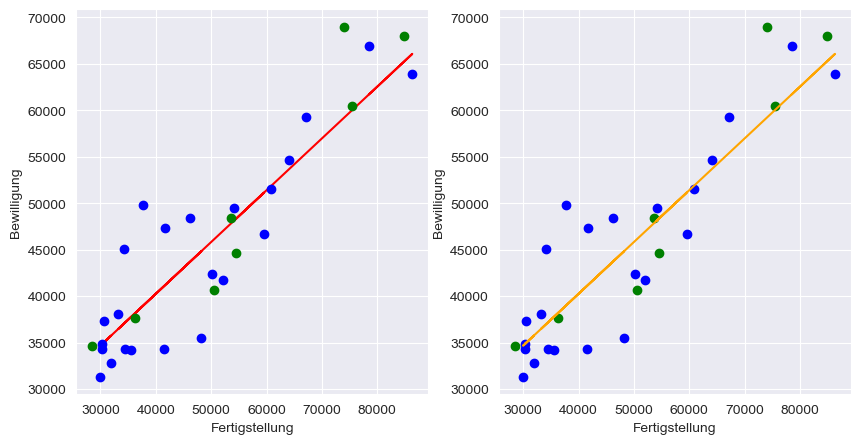

In [20]:
plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(df_flats_train[indi_feature], coeff_val(sreg_skl.coef_[0]) * df_flats_train[indi_feature] + coeff_val(sreg_skl.intercept_), 'r', label='Regression sklearn')
plt.plot(df_flats_test[indi_feature], df_flats_test[predict_feature], 'go', label='Testdaten')
plt.plot(df_flats_train[indi_feature], df_flats_train[predict_feature], 'bo', label='Trainingsdaten')
plt.xlabel(predict_feature)
plt.ylabel(indi_feature)

plt.subplot(1,2,2)
plt.plot(df_flats_test[indi_feature], df_flats_test[predict_feature], 'go', label='Testdaten')
plt.plot(df_flats_train[indi_feature], df_flats_train[predict_feature], 'bo', label='Trainingsdaten')
plt.plot(df_flats_train[indi_feature], w_original*df_flats_train[indi_feature] + b_original, color='orange', label='Regression pyTorch')
plt.xlabel(predict_feature)
plt.ylabel(indi_feature)


R$^2$ Score.

In [22]:
fx_sklearn = sreg_skl.predict(df_flats_train[[indi_feature]])
indi_values = df_flats_train[[indi_feature]].to_numpy()

model.eval()
train_tensor = torch.tensor(indi_values, dtype=torch.float32)

# Make predictions with no_grad() context to save memory and computations
with torch.no_grad():
    predictions = model(train_tensor)

# Convert predictions to numpy (optional)
fx_pytorch = predictions.numpy()

r2_training_sklearn = r2_score(y_true=df_flats_train[predict_feature], y_pred=fx_sklearn)
r2_training_pytorch = r2_score(y_true=df_flats_train[predict_feature], y_pred=fx_pytorch)

print(f'R^2 Score auf den Trainingsdaten für sklearn: {r2_training_sklearn}')
print(f'R^2 Score auf den Trainingsdaten für pytorch: {r2_training_pytorch}')

R^2 Score auf den Trainingsdaten für sklearn: 0.7711564476519542
R^2 Score auf den Trainingsdaten für pytorch: 0.4313058853149414


## RNN pytorch try

In [30]:
# Feature columns and target column
feature_columns = ['Bewilligung', 'Bewilligungen vor 1 Jahr', 'Bewilligungen vor 2 Jahren', 
                   'Bewilligungen vor 3 Jahren', 'Bewilligungen vor 4 Jahren']
target_column = 'Fertigstellung'

# Extract features and target
X = df_flats_train[feature_columns].values
y = df_flats_train[target_column].values

# Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=202410, shuffle=True)

# Scale the data
X_train = X_train/10000
X_test = X_test/10000

# Convert data to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Reshape for RNN input (samples, sequence_length, input_dim)
X_train = X_train.view(X_train.size(0), 1, X_train.size(1))
X_test = X_test.view(X_test.size(0), 1, X_test.size(1))
y_train = y_train.view(-1, 1)
y_test = y_test.view(-1, 1)

In [32]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Fully connected layer
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        # Set initial hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))  # out: tensor of shape (batch_size, seq_length, hidden_size)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Model parameters
input_size = X_train.size(2)
hidden_size = 50
output_size = 1
num_layers = 1

# Instantiate the model
model = RNNModel(input_size, hidden_size, output_size, num_layers)

In [34]:
# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [36]:
# Training parameters
num_epochs = 5000
for epoch in range(num_epochs):
    model.train()
    
    # Forward pass
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    
    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

In [37]:
model.eval()
with torch.no_grad():
    train_predictions = model(X_train)
    test_predictions = model(X_test)

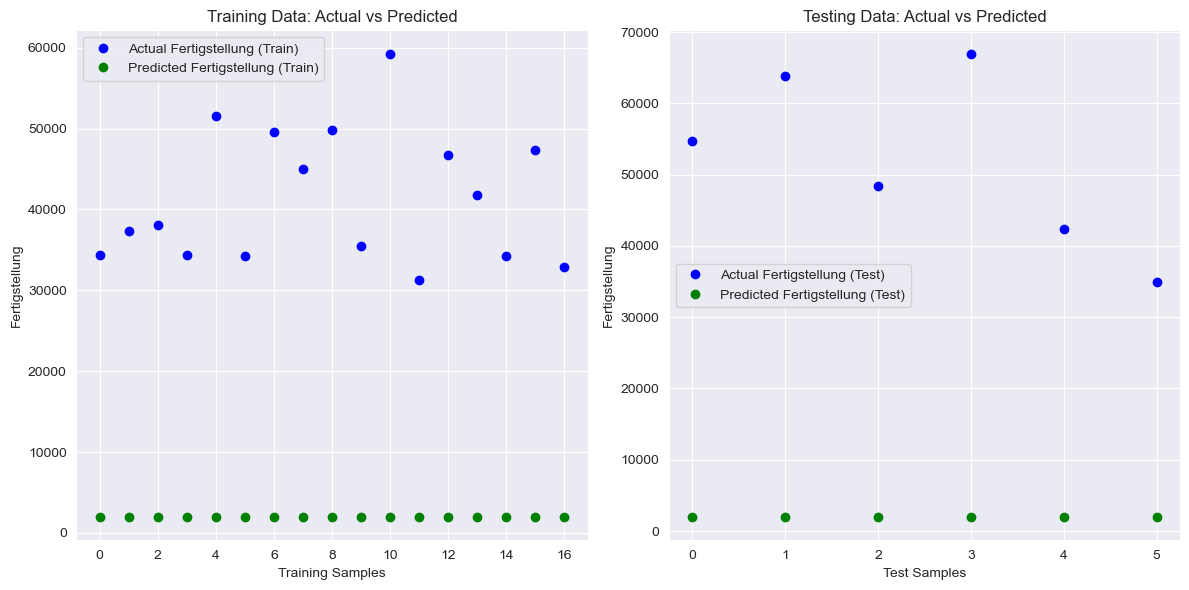

In [40]:
# Convert PyTorch tensors to numpy arrays for plotting
train_predictions = train_predictions.numpy() if torch.is_tensor(train_predictions) else train_predictions
test_predictions = test_predictions.numpy() if torch.is_tensor(test_predictions) else test_predictions

# Plotting the training results
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(y_train,'bo', label='Actual Fertigstellung (Train)')
plt.plot(train_predictions,'go', label='Predicted Fertigstellung (Train)')
plt.title("Training Data: Actual vs Predicted")
plt.xlabel("Training Samples")
plt.ylabel("Fertigstellung")
plt.legend()

# Plotting the test results
plt.subplot(1, 2, 2)
plt.plot(y_test,'bo', label='Actual Fertigstellung (Test)')
plt.plot(test_predictions,'go', label='Predicted Fertigstellung (Test)')
plt.title("Testing Data: Actual vs Predicted")
plt.xlabel("Test Samples")
plt.ylabel("Fertigstellung")
plt.legend()

plt.tight_layout()
plt.show()
